In [30]:
import pandas as pd 
import numpy as np
import re
import copy
from datetime import datetime as dt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing
from sklearn.manifold import TSNE
from scipy.optimize import curve_fit

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

本プロジェクトで使用するデータは、こちらからダウンロードしてください。

https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014

＜ダウンロードの手順＞
1. 上記のURLにアクセス
2. ページ上部にある、" Data Folder"（黄色の箇所）をクリック
3. LD2011_2014.txt.zipをダウンロード

※使用するデータは、サイズが大きいのでダウンロードに数分〜數十分ほど時間がかかります



In [31]:
dataset = pd.read_table("LD2011_2014.txt", sep =";")

c:\users\c25351\anaconda\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,125,126,127,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,157,160,164,165,167,170,173,177,178,179,181,184,185,186,223,224,255,280,289,305,308,322,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,363,364,365,366,367,368,369,370) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
dataset.head()

,Unnamed: 0,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 00:15:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
1,2011-01-01 00:30:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2,2011-01-01 00:45:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
3,2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
4,2011-01-01 01:15:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0


In [33]:
#最初の1000行をCSVファイルで書き出してみる
#mydata = dataset.ix[0:1000]
#mydata.to_csv("mydata,csv", index=False)

In [34]:
# 行数と列数を確認
dataset.shape

(140256, 371)

In [35]:
# 列数ごとにデータ型を確認
for col in dataset.columns:
    print(col, type(dataset[col].ix[0]))

Unnamed: 0 <class 'str'>
MT_001 <class 'int'>
MT_002 <class 'int'>
MT_003 <class 'int'>
MT_004 <class 'int'>
MT_005 <class 'int'>
MT_006 <class 'int'>
MT_007 <class 'int'>
MT_008 <class 'int'>
MT_009 <class 'int'>
MT_010 <class 'int'>
MT_011 <class 'int'>
MT_012 <class 'int'>
MT_013 <class 'int'>
MT_014 <class 'int'>
MT_015 <class 'int'>
MT_016 <class 'int'>
MT_017 <class 'int'>
MT_018 <class 'int'>
MT_019 <class 'int'>
MT_020 <class 'int'>
MT_021 <class 'int'>
MT_022 <class 'int'>
MT_023 <class 'int'>
MT_024 <class 'int'>
MT_025 <class 'int'>
MT_026 <class 'int'>
MT_027 <class 'int'>
MT_028 <class 'int'>
MT_029 <class 'int'>
MT_030 <class 'int'>
MT_031 <class 'int'>
MT_032 <class 'int'>
MT_033 <class 'int'>
MT_034 <class 'int'>
MT_035 <class 'int'>
MT_036 <class 'int'>
MT_037 <class 'int'>
MT_038 <class 'int'>
MT_039 <class 'int'>
MT_040 <class 'int'>
MT_041 <class 'int'>
MT_042 <class 'int'>
MT_043 <class 'int'>
MT_044 <class 'int'>
MT_045 <class 'int'>
MT_046 <class 'int'>
MT_047 <c

c:\users\c25351\anaconda\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
# データ型が一部文字列型になっていることがわかる。
# その理由は、小数点がカンマになっているため。
# str型をfloat型にするために、数値の,を.に変換

dataset = dataset.replace(r",", ".",regex = True)  

#列"Unnamed: 0"の名前を"time"に変更
dataset.rename(columns = {"Unnamed: 0": "time"}, inplace = True)

# time以外は全て小数点型にするので、timeを一度切り離して、float型に変更
data = dataset.drop("time", axis = 1)  # "time"のみ別扱いとする
data = data.astype("float")  # 数値をfloat型へ変換

In [37]:
#kWhに直す(UCIの説明書きにあるように4で割ってkWhに修正 )
data = data/4

# 元のデータが法人顧客データなので、500（これは適当）で割って個人宅レベルの電力量に変換
data = data/500

# 最後にtime列を作成
data["time"] = dataset["time"]

In [38]:
# CSVファイルに書き出す
#data.to_csv("data_converted.csv", index=False)

In [39]:
# 要約統計量を確認
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,0.001985,0.010384,0.001459,0.041092,0.018620,0.070614,0.002261,0.095701,0.019988,0.021103,...,0.109107,18.803994,0.943714,1.470016,0.032707,0.004635,0.212131,0.047352,0.312626,4.361178
std,0.002992,0.006636,0.005507,0.029124,0.013231,0.049220,0.003243,0.060991,0.014907,0.016701,...,0.102417,19.345977,0.900743,1.366126,0.032504,0.005008,0.137169,0.040149,0.190328,4.597578
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.001422,0.000000,0.018293,0.007927,0.035714,0.000283,0.055556,0.006993,0.004839,...,0.002855,0.000000,0.000000,0.000000,0.006519,0.000000,0.000000,0.015025,0.041972,0.000000
50%,0.000635,0.012447,0.000869,0.043699,0.019512,0.078869,0.001413,0.111111,0.020105,0.020430,...,0.065667,12.050000,0.525316,1.068182,0.015645,0.003511,0.262950,0.038397,0.379032,0.000000
75%,0.001269,0.014936,0.000869,0.057927,0.027439,0.102679,0.002261,0.139731,0.028846,0.030645,...,0.201642,27.400000,1.656118,2.681818,0.054107,0.005851,0.313872,0.075960,0.437683,8.891892
max,0.024112,0.057610,0.075586,0.160569,0.075000,0.267857,0.022329,0.276094,0.078671,0.099462,...,0.426481,96.400000,3.875527,6.193182,0.167536,0.030135,0.569359,0.181135,0.774560,15.459459


In [40]:
# time列から　月、日、曜日、時を抜き出すために関数を用意
# + 年を入れておく

def get_year_from_time(x):
    time_date = dt.strptime(x, "%Y-%m-%d %H:%M:%S")
    return time_date.year

def get_month_from_time(x):
    time_date = dt.strptime(x, "%Y-%m-%d %H:%M:%S")
    return time_date.month
def get_day_from_time(x):
    time_date = dt.strptime(x, "%Y-%m-%d %H:%M:%S")
    return time_date.day
def get_weekday_from_time(x):
    time_date = dt.strptime(x, "%Y-%m-%d %H:%M:%S")
    return time_date.weekday()
def get_hour_from_time(x):
    time_date = dt.strptime(x, "%Y-%m-%d %H:%M:%S")
    return time_date.hour

In [41]:
# 上記で作成した関数をapplyで一括適用
data["year"] = data["time"].apply(get_year_from_time)
data["month"] = data["time"].apply(get_month_from_time)
data["day"] = data["time"].apply(get_day_from_time)
data["weekday"] = data["time"].apply(get_weekday_from_time)
data["hour"] = data["time"].apply(get_hour_from_time)

In [42]:
print(data.shape)
data.head()

(140256, 376)


,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_367,MT_368,MT_369,MT_370,time,year,month,day,weekday,hour
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2011-01-01 00:15:00,2011,1,1,5,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2011-01-01 00:30:00,2011,1,1,5,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2011-01-01 00:45:00,2011,1,1,5,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2011-01-01 01:00:00,2011,1,1,5,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2011-01-01 01:15:00,2011,1,1,5,1


In [43]:
#data.to_csv("data01.csv", index=False)
#mydata2 = data.ix[0:1000]
#mydata2.to_csv("mydata2.csv", index=False)
#timeをドロップ
data = data.drop("time", axis = 1)
print(data.shape)
data.head()

(140256, 375)


,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_366,MT_367,MT_368,MT_369,MT_370,year,month,day,weekday,hour
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2011,1,1,5,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2011,1,1,5,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2011,1,1,5,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2011,1,1,5,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2011,1,1,5,1


In [44]:
#1時間ごとにまとめ
#data2 = pd.DataFrame([0], index = [data.index.shift()[0]])
#data2.append(data).groupby(pd.TimeGouper(freq = "1H")).aggregate(np.sum)[1:]


In [45]:
#yearごとの合計を算出、データ開始日を見極め
data_groupby = data.groupby("year").sum()
data_groupby

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,month,day,weekday,hour
year,,,,,,,,,,,,,,,,,,,,,
2011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,228671,550847,105307,402960
2012,96.565990,471.575036,136.157689,1750.983740,828.568902,3265.602679,84.433861,4463.148148,966.257867,934.682258,...,1776.273794,224.534231,10238.466198,2190.196160,15103.544721,0.000000,228864,553632,105408,404064
2013,110.796954,517.458748,38.546481,1892.281504,871.896341,3372.696429,129.903053,4559.436027,946.699301,1065.438172,...,1354.085398,229.626682,9516.107550,2246.868114,14539.018695,301328.835135,228672,550848,104928,402960
2014,71.098985,467.408250,29.950043,2120.079268,911.081098,3265.555060,102.730356,4399.893939,890.402972,959.607527,...,1456.920469,195.903160,9997.820896,2204.322204,14204.753666,310348.918919,228672,550848,105024,402960
2015,0.001269,0.009957,0.000869,0.089431,0.042073,0.139881,0.005088,0.124579,0.031469,0.034946,...,0.013690,0.002048,0.314311,0.065943,0.336510,3.567568,1,1,3,0


In [46]:
data_groupby.to_csv("data_groupby.csv", index=False)

In [47]:
#2014抜粋
data2014 = data.loc[data.year == 2014]
print(data2014.shape)
data2014.head()

(35040, 375)


,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_366,MT_367,MT_368,MT_369,MT_370,year,month,day,weekday,hour
105215,0.001269,0.012447,0.000869,0.076220,0.038415,0.145833,0.003674,0.126263,0.027098,0.033871,...,0.003511,0.123354,0.023372,0.356305,3.459459,2014,1,1,2,0
105216,0.001269,0.011735,0.000000,0.075203,0.036585,0.144345,0.003109,0.117845,0.023601,0.033871,...,0.004096,0.119842,0.023372,0.370968,3.783784,2014,1,1,2,0
105217,0.001269,0.011735,0.000000,0.074187,0.039024,0.133929,0.003392,0.126263,0.026224,0.033871,...,0.005266,0.115891,0.024207,0.367302,3.675676,2014,1,1,2,0
105218,0.001269,0.012091,0.000000,0.072154,0.037195,0.127976,0.003109,0.124579,0.025350,0.031720,...,0.005851,0.115891,0.021703,0.354839,3.783784,2014,1,1,2,0
105219,0.001269,0.011735,0.000000,0.068089,0.037195,0.126488,0.003109,0.124579,0.026224,0.036022,...,0.006437,0.116330,0.025042,0.347874,3.621622,2014,1,1,2,1


In [48]:
#欠損顧客を削除
data2014c = data2014.drop(columns =["MT_003","MT_040","MT_131","MT_159","MT_223","MT_348"])
print(data2014c.shape)
data2014c.head()

(35040, 369)


,MT_001,MT_002,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,...,MT_366,MT_367,MT_368,MT_369,MT_370,year,month,day,weekday,hour
105215,0.001269,0.012447,0.076220,0.038415,0.145833,0.003674,0.126263,0.027098,0.033871,0.027943,...,0.003511,0.123354,0.023372,0.356305,3.459459,2014,1,1,2,0
105216,0.001269,0.011735,0.075203,0.036585,0.144345,0.003109,0.117845,0.023601,0.033871,0.027571,...,0.004096,0.119842,0.023372,0.370968,3.783784,2014,1,1,2,0
105217,0.001269,0.011735,0.074187,0.039024,0.133929,0.003392,0.126263,0.026224,0.033871,0.027571,...,0.005266,0.115891,0.024207,0.367302,3.675676,2014,1,1,2,0
105218,0.001269,0.012091,0.072154,0.037195,0.127976,0.003109,0.124579,0.025350,0.031720,0.028316,...,0.005851,0.115891,0.021703,0.354839,3.783784,2014,1,1,2,0
105219,0.001269,0.011735,0.068089,0.037195,0.126488,0.003109,0.124579,0.026224,0.036022,0.028689,...,0.006437,0.116330,0.025042,0.347874,3.621622,2014,1,1,2,1


In [49]:
#monthでgroupby
data_groupby_month = data2014c.groupby("month").sum()
data_groupby_month

,MT_001,MT_002,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,...,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,year,day,weekday,hour
month,,,,,,,,,,,,,,,,,,,,,
1,3.610406,42.207681,208.329268,104.953659,343.504464,7.847654,400.772727,92.358392,90.008065,75.125186,...,87.065841,13.963136,562.724320,206.951586,1104.876466,19954.675676,5993664,47616,8928,34224
2,3.053299,33.789829,197.910569,94.132317,318.605655,7.305822,360.831650,79.464161,82.213978,69.499627,...,80.757497,12.438853,746.034680,182.470785,1003.985704,18729.270270,5413632,38976,8064,30912
3,3.555838,34.689189,190.878049,84.346951,288.933036,6.772188,350.090909,70.075175,74.082796,60.637481,...,87.187744,15.034523,823.874451,184.627713,1126.376100,22742.891892,5993664,47616,9120,34224
4,4.180838,34.783784,173.207317,67.628659,254.944940,5.617863,333.925926,63.043706,71.051075,51.577124,...,82.557366,17.005851,842.514486,178.797997,1106.443182,25993.135135,5800320,44640,8352,33120
5,7.043147,38.131223,161.632114,57.736585,237.196429,4.798191,345.538721,58.312937,69.802151,50.775708,...,93.271186,15.644822,868.996049,182.981636,1188.134897,28260.756757,5993664,47616,9216,34224
6,3.215736,38.768137,155.172764,54.731707,229.550595,4.319107,346.523569,60.727273,67.952688,48.861401,...,115.668188,18.941194,862.516681,175.984975,1213.446114,29106.837838,5800320,44640,8640,33120
7,3.385787,48.324680,162.754065,72.820122,247.016369,22.779254,383.062290,74.461538,76.221505,55.487332,...,163.930900,17.914570,938.988147,183.890651,1338.616202,31029.729730,5993664,47616,8640,34224
8,22.769670,48.196657,159.592480,61.219512,226.339286,16.783776,379.718855,65.260490,64.116129,55.174739,...,147.199478,18.320363,924.624232,178.954925,1396.266129,30516.810811,5993664,47616,9504,34224
9,11.861041,42.614509,156.195122,60.206707,236.955357,7.020916,352.917508,79.190559,79.191398,50.876677,...,168.574316,17.303979,877.630817,177.778798,1244.286290,29742.540541,5800320,44640,8160,33120


In [50]:
data_groupby_month.to_csv("data_groupby_month.csv", index=False)

In [51]:
#7月を抜粋
data201407 = data2014c.loc[data2014c.month == 7]
print(data201407.shape)
data201407.head()

(2976, 369)


,MT_001,MT_002,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,...,MT_366,MT_367,MT_368,MT_369,MT_370,year,month,day,weekday,hour
122591,0.000635,0.013869,0.059959,0.021951,0.081845,0.002261,0.124579,0.028846,0.019355,0.020492,...,0.017262,0.387621,0.101002,0.404326,11.729730,2014,7,1,1,0
122592,0.000635,0.013514,0.057927,0.020732,0.078869,0.002261,0.122896,0.021853,0.019892,0.019001,...,0.010240,0.368306,0.106010,0.391862,12.054054,2014,7,1,1,0
122593,0.001269,0.012802,0.059959,0.019512,0.080357,0.001979,0.107744,0.025350,0.021505,0.019001,...,0.005266,0.386743,0.101836,0.385630,11.486486,2014,7,1,1,0
122594,0.000635,0.013158,0.063008,0.019512,0.075893,0.001696,0.106061,0.026224,0.019892,0.018256,...,0.003803,0.377963,0.097663,0.388563,11.594595,2014,7,1,1,0
122595,0.000635,0.011735,0.057927,0.019512,0.065476,0.001696,0.106061,0.027972,0.018817,0.016766,...,0.004096,0.353819,0.095993,0.381232,11.675676,2014,7,1,1,1


In [52]:
#weekdayをweekday/holidayとする
data201407W1 = data201407.loc[data201407.weekday < 5]
data201407H1 = data201407.loc[data201407.weekday > 4]


#15mごと -> 1hourごと@weekday
data201407W = data201407W1.groupby(["hour"], as_index =  False).sum().drop(columns = ["year","month","day","weekday"])
print(data201407W.shape)
data201407W.head()

(24, 365)


,hour,MT_001,MT_002,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,0,0.128807,1.429587,6.167683,2.729878,7.520833,0.763426,10.784512,2.295455,2.254301,...,5.988223,1347.85,48.316456,98.545455,3.704694,0.726448,35.330553,7.764608,37.519428,974.891892
1,1,0.136421,1.183855,5.057927,2.403659,6.523810,0.730639,9.767677,2.209790,2.080108,...,4.192006,830.40,35.126582,52.068182,2.945241,0.717379,33.297629,5.935726,36.071848,965.972973
2,2,0.138325,1.115220,4.493902,2.261585,5.827381,0.730073,8.925926,2.154720,2.018817,...,4.035332,749.20,31.537975,50.284091,2.512386,0.576653,31.548288,4.161102,35.835411,957.378378
3,3,0.142766,1.121977,4.407520,2.111585,5.602679,0.730356,10.823232,2.155594,2.010753,...,4.015346,651.40,30.578059,46.852273,2.400913,0.348449,28.539947,3.606845,35.170455,932.324324
4,4,0.141497,1.149360,4.419715,2.106098,5.815476,0.724421,9.821549,2.123252,1.970968,...,4.005710,569.50,30.622363,45.068182,2.391786,0.338795,27.083406,3.261269,34.570381,934.324324


In [53]:
#15mごと -> 1hourごと@holiday
data201407H = data201407H1.groupby(["hour"], as_index =  False).sum().drop(columns = ["year","month","day","weekday"])
print(data201407H.shape)
data201407H.head()

(24, 365)


,hour,MT_001,MT_002,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,0,0.031091,0.511380,2.158537,0.995122,2.629464,0.268796,3.993266,0.872378,0.783333,...,2.570307,519.65,17.164557,35.590909,1.295306,0.318900,11.431958,1.708681,13.030059,344.486486
1,1,0.027284,0.430654,1.803862,0.890244,2.364583,0.253250,3.695286,0.841783,0.697849,...,2.364383,385.30,13.921941,18.397727,1.059974,0.287888,10.807287,1.276294,12.572947,335.729730
2,2,0.028553,0.410028,1.592480,0.821341,2.107143,0.250424,3.673401,0.806818,0.688172,...,1.854747,328.30,13.643460,17.443182,0.996089,0.211235,10.388499,1.008347,12.423754,331.567568
3,3,0.027919,0.405405,1.541667,0.776220,2.000000,0.249859,3.777778,0.792832,0.695161,...,1.528908,264.75,12.037975,16.272727,0.989570,0.185489,8.485075,0.955760,12.141496,325.891892
4,4,0.027284,0.411451,1.549797,0.754878,2.043155,0.249011,3.720539,0.776224,0.690323,...,1.621699,195.15,11.481013,15.488636,0.997392,0.166179,7.618525,0.925710,12.132698,338.270270


In [54]:
##8:00- 20:00のみにする
#data2014070820 = data201407t.loc[data201407t.hour == 8]
#print(data20140820.shape)
#data201407t.head()

In [55]:
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#sc.fit(data201407W)
#data201407AA = sc.transform(data201407W)
#print(data201407AA.shape)
#data201407AA

In [56]:
#from sklearn.decomposition import PCA
#pca = PCA(n_components=2)
#A = pca.fit(data201407W.drop(columns = ["hour"]))
#A
#print(pca.components_)

In [57]:
#TSNE
X=data201407W
for i in X.drop([ "hour"], axis=1).columns:
    X[i] = preprocessing.scale(X[i])
X=X.drop(["hour"],axis=1).T
print(X)
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(X)

              0         1         2         3         4         5         6   \
MT_001  0.061793  0.148605  0.170308  0.220948  0.206480  0.155839  0.003919   
MT_002 -0.305092 -1.528117 -1.869714 -1.836085 -1.699801 -1.122802 -0.133409   
MT_004  1.017840  0.015716 -0.493606 -0.571610 -0.560598 -1.010269 -1.786641   
MT_005  0.912035  0.229365 -0.067948 -0.381849 -0.393333 -0.421406 -1.426909   
MT_006 -0.149614 -0.775470 -1.212635 -1.353686 -1.220108 -1.453636 -1.988883   
MT_007  0.397970 -0.055179 -0.062992 -0.059085 -0.141121 -0.164559 -0.938037   
MT_008 -0.635748 -1.176614 -1.624350 -0.615152 -1.147959 -0.999310 -2.126710   
MT_009 -0.210751 -0.433833 -0.577242 -0.574966 -0.659191 -0.178883 -2.131984   
MT_010 -0.387241 -0.589537 -0.660716 -0.670081 -0.716285 -0.805570 -1.936307   
MT_011  0.407012 -0.388341 -0.769215 -0.980811 -0.974588 -0.963386 -2.132144   
MT_012 -0.741628 -0.965966 -1.215309 -1.351054 -1.438217 -1.586108 -1.901180   
MT_013 -1.081383 -1.020481 -1.134628 -1.

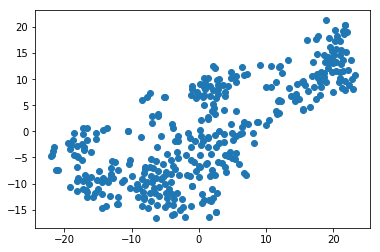

In [58]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])

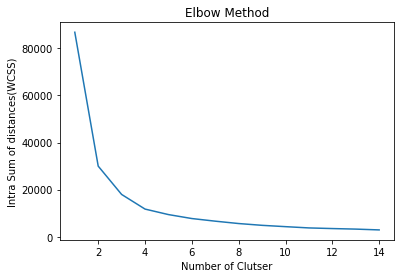

In [59]:
max_cluster = 15
clusters_ = range(1, max_cluster)
intra_sum_of_square_list = []
plt.figure(0)
for k in clusters_:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300)
    km.fit(X_reduced)
    intra_sum_of_square_list.append(km.inertia_)

fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Elbow Method')
ax.set_xlabel('Number of Clutser')
ax.set_ylabel('Intra Sum of distances(WCSS)')
plt.plot(clusters_, intra_sum_of_square_list)

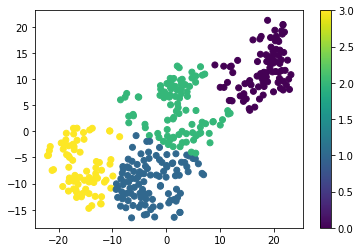

In [60]:
km = KMeans(n_clusters= 4)
km.fit(X_reduced)
pred_4 = km.predict(X_reduced)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1],c=pred_4)
plt.colorbar()

In [61]:
#cluster_labels = labels["0"].values
cluster_labels = pred_4
clustered = pd.DataFrame(cluster_labels).T
clustered.columns=(X.T.columns)
clustered.index=(["cluster"])

In [62]:
#Holiday
#TSNE
Y=data201407H
for i in Y.drop([ "hour"], axis=1).columns:
    Y[i] = preprocessing.scale(Y[i])
Y=Y.drop(["hour"],axis=1).T
print(Y)
Y_reduced = TSNE(n_components=2, random_state=0).fit_transform(Y)

              0         1         2         3         4         5         6   \
MT_001  1.713787  1.227031  1.389283  1.308157  1.227031  1.308157  0.659149   
MT_002 -0.182670 -1.492125 -1.826699 -1.901690 -1.803625 -1.301764 -0.344189   
MT_004  1.287899  0.194171 -0.457679 -0.614373 -0.589302 -1.187875 -2.447700   
MT_005  1.573369  0.926276  0.501152  0.222751  0.091076  0.008308 -0.988665   
MT_006  0.205662 -0.360075 -0.909920 -1.138758 -1.046587 -1.386665 -2.114495   
MT_007  1.869873  1.334465  1.237118  1.217648  1.188444  1.110567  0.438873   
MT_008  0.026208 -0.621064 -0.668604 -0.441876 -0.566210 -1.008696 -2.449515   
MT_009  1.175567  0.929559  0.648407  0.535946  0.402399  0.929559 -1.150966   
MT_010  1.383294  0.777458  0.708873  0.758406  0.724114  0.541220 -1.840211   
MT_011  0.765324 -0.160405 -0.719106 -0.967870 -0.943402 -1.029042 -2.350348   
MT_012 -0.027244 -0.347364 -0.878627 -1.018254 -1.195342 -1.478001 -2.002453   
MT_013 -0.247096  0.018837 -0.645995 -0.

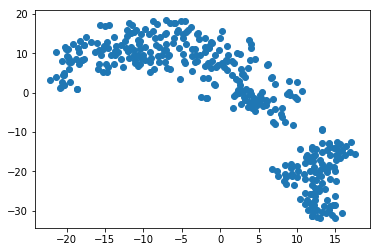

In [63]:
plt.scatter(Y_reduced[:, 0], Y_reduced[:, 1])

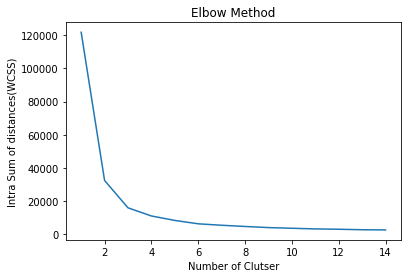

In [64]:
max_cluster = 15
clusters_ = range(1, max_cluster)
intra_sum_of_square_list = []
plt.figure(0)
for k in clusters_:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300)
    km.fit(Y_reduced)
    intra_sum_of_square_list.append(km.inertia_)

fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Elbow Method')
ax.set_xlabel('Number of Clutser')
ax.set_ylabel('Intra Sum of distances(WCSS)')
plt.plot(clusters_, intra_sum_of_square_list)

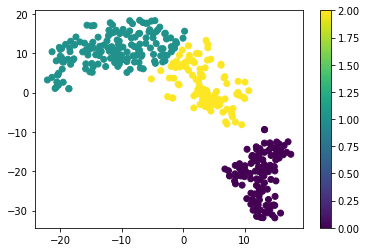

In [65]:
km = KMeans(n_clusters= 3)
km.fit(Y_reduced)
pred_3 = km.predict(Y_reduced)

plt.scatter(Y_reduced[:, 0], Y_reduced[:, 1],c=pred_3)
plt.colorbar()

In [66]:
data201407H.to_csv("data201407H.csv", index=False)
data201407W.to_csv("data201407W.csv", index=False)
np.savetxt("pred_3.csv",pred_3,delimiter=",")
np.savetxt("pred_4.csv",pred_4,delimiter=",")

In [67]:
#print("--- explained_variance_ratio_ ---")
#print(pca.explained_variance_ratio_)
#print("--- components ---")
#print(pca.components_)
#print("--- mean ---")
#print(pca.mean_)
#print("--- covariance ---")
#print(pca.get_covariance())

In [68]:
#A_2d = pca.transform(A)
# fit_transform 呼出しで両方が同時に実行可能。
#A_2d = pd.DataFrame(A_2d)
#A_2d.index = A.index
#A_2d.columns = ['PC1','PC2']
#A_2d.head()